<b> Exercise 1:</b> Convolutional AutoEncoder

<ol>
<li>Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.</li>
<li>Implement a convolutional autoencoder (with separate Encoder and Decoder modules).</li>
<li>Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.</li>
<li>Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.</li>
<li>Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.</li>
<li>Generate 5 new images by injecting random values as input to the decoder. Show them.</li>

</ol>


<h3><b> Import Libraries</b>
</h3>

In [0]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

from torch import optim, nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.functional import F
from collections import defaultdict

<h3><b>Setting the seed for the pseudo-random number generators </b></h3>

In [0]:
# Set seed for reproducibility
seed = 50 
torch.manual_seed(seed)
np.random.seed(seed)

In [0]:
hparams = {
    'batch_size':256, 
    'num_epochs':10,
    'test_batch_size': 256,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_batch_freq': 10,
    'train_ratio': 0.8
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

<h3><b> Loading the Dataset</b></h3>
The transformations passed with the kwarg <b>transform=</b> are used to have zero-mean and unit-variance data. The first value is the dataset mean, whether the second is its variance.

In [8]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

0it [00:00, ?it/s]

9920512it [00:01, 8464413.49it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129369.89it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2124991.09it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 49522.63it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


<b><h3> Get 5% of train samples as validation samples</b> </h3>


In [9]:
train_size = len(mnist_trainset)
print('train_size {}'.format(train_size))
validation_size = np.floor(0.05*train_size)
print('validation_size {}'.format(validation_size))
train_samples, validation_samples = torch.utils.data.random_split(mnist_trainset, (int(train_size - validation_size), int(validation_size)))

train_size 60000
validation_size 3000.0


In [0]:
# Create iterables with sequences of length batch_size elements
train_loader = torch.utils.data.DataLoader(train_samples, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_samples, batch_size=len(validation_samples),
                                          shuffle=False)

<b><h3> Convolutional Encoder </b></h3>

In [0]:
class ConvEncoder(nn.Module):
  """
  :param bottleneck: Number of dimensions of the reduced representation.
  :param pooling_size: Pooling filter size.
  :param filter_size: Size of the convolutional filter
  :param N_filters: Number of convolutionals filters
  """

  def __init__(self, bottleneck, pooling_size=2, filter_size=3, N_filters=32):
    super().__init__()
    self.bottleneck = bottleneck
    self.N_filters = N_filters

    self.conv1 = nn.Conv2d(1,N_filters,filter_size,padding=1,stride=1) # 1 to N_filters channels, 3x3 filter, same spatial dimension
    self.pool  = nn.MaxPool2d(pooling_size, pooling_size)
    self.conv2 = nn.Conv2d(N_filters,N_filters*2,filter_size,padding=1,stride=1) # N_filters to N_filters*2 channels, 3x3 filter, same spatial dimension
    self.fc = nn.Sequential(
        nn.Linear(7*7*N_filters*2, self.bottleneck),
        nn.ReLU()
      )

    #self.fc_classif = nn.Sequential(
    #    nn.Linear(7*7*16, 10),
    #    nn.Softmax()
    #  )

  def forward(self, x):
    """
    Encodes 28x28-dimensional images into self.bottleneck-dimensional images.
    """
    # Input: batch_size x 28 x 28 x 1
    x = F.relu(self.conv1(x))
    # Output: batch_size x 28 x 28 x N_filters
    x = self.pool(x)
    # Output: batch_size x 14 x 14 x N_filters
    x = F.relu(self.conv2(x))
    # Output: batch_size x 14 x 14 x N_filters*2
    x = self.pool(x)  
    # Output: batch_size x 7 x 7 x N_filters*2
    x = x.view(-1, 7*7*self.N_filters*2)
  
    # Projection Layer that compresses original representation into sub-space 
    # of *bottleneck* dimensions
    #x = self.fc_classif(x)
    x = self.fc(x)
    
    # Return compressed representation
    return x

<b><h3> Convolutional Decoder </b></h3>

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self, bottleneck, filter_size=2, N_filters=32):
    """
    :param bottleneck: Number of dimensions of the reduced representation.
    :param pooling_size: Pooling filter size.
    :param filter_size: Size of the convolutional filter
    :param N_filters: Number of convolutionals filters
    """
    super().__init__()
    self.bottleneck = bottleneck
    self.N_filters = N_filters

    self.trans_conv1 = nn.ConvTranspose2d(self.N_filters*2, self.N_filters, filter_size, stride=2) # 64 to 32 channels, with 2x spatial dimension upsampling (stride == filter_size == 2)
    self.trans_conv2 = nn.ConvTranspose2d(self.N_filters, 1, filter_size, stride=2) # 64 to 32 channels, with 2x spatial dimension upsampling (stride == filter_size == 2)
    self.fc = nn.Sequential(
        nn.Linear(self.bottleneck, 7*7*self.N_filters*2),
        nn.ReLU()
    )
    
  def forward(self, x):
    """
    Decodes (reconstructs) self.bottleneck-dimensional images into 784-dimensional images.
    """
    x = self.fc(x)
    x = x.view(-1, self.N_filters*2, 7, 7)
    x = F.relu(self.trans_conv1(x))
    x = F.relu(self.trans_conv2(x))

    return x

In [0]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, bottleneck):
    super().__init__()
    self.encoder = ConvEncoder(bottleneck)
    self.decoder = ConvDecoder(bottleneck)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


<h3><b>Define Train and Test/Validation methods</b></h3>

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      target = F.one_hot(target, 10)
      data, target = data.to(device), target.to(device, dtype= torch.float)
      optimizer.zero_grad()
      output = network(data)
      # we pass data as the "target" because we want to measure the MSE between 
      # output and input.
      loss = criterion(output, data)
      loss.backward()
      optimizer.step()
      avg_loss = loss.item()
      network.state_dict()
      if batch_idx % hparams['log_batch_freq'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [0]:
def test_epoch(test_loader, network, criterion, hparams, validation=False):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = F.one_hot(target, 10)
            data, target = data.to(device), target.to(device, dtype= torch.float)
            output = network(data)
            test_loss += criterion(output, data).item() # sum up batch loss
    test_acc = 0
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Test' if validation is False else 'Validation', test_loss, acc, 
        len(test_loader.dataset), test_acc,
        ))
    return test_loss

<h3><b> Define the optimizer with MSE Loss</h3></b>

In [0]:
criterion = nn.MSELoss()

# <h3><b>Training Loop</h3></b>

In [21]:
# [8, 16, 32, 64, 128] We want an ordered set, so we use list() instead of set()
bottleneck_set = [2**(i+3) for i in range(5)] 
bottleneck = 128
# Define a losses dictionary with keys the bottleneck size and values the 
# train, validation losses. We will use this to monitor the model performance 
# later.  
losses = dict()
#for bottleneck in bottleneck_set:
print("Training ConvAutoEncoder with bottleneck: {}".format(bottleneck))
net = ConvAutoEncoder(bottleneck)
optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])

train_losses = []
validation_losses = []
for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(train_loader, net, optimizer, criterion, hparams))
  validation_losses.append(test_epoch(validation_loader, net, criterion, hparams, validation=True))
  #validation_accs.append(validation_acc)
losses.update({bottleneck: {"train_loss": train_losses, "val_loss": validation_losses}})

Training ConvAutoEncoder with bottleneck: 128
Train Epoch: 1 [0/57000 (0%)]	Loss: 1.030546
Train Epoch: 1 [2560/57000 (4%)]	Loss: 0.825290
Train Epoch: 1 [5120/57000 (9%)]	Loss: 0.750873
Train Epoch: 1 [7680/57000 (13%)]	Loss: 0.669495
Train Epoch: 1 [10240/57000 (18%)]	Loss: 0.567982
Train Epoch: 1 [12800/57000 (22%)]	Loss: 0.510855
Train Epoch: 1 [15360/57000 (27%)]	Loss: 0.453002
Train Epoch: 1 [17920/57000 (31%)]	Loss: 0.429594
Train Epoch: 1 [20480/57000 (36%)]	Loss: 0.396130
Train Epoch: 1 [23040/57000 (40%)]	Loss: 0.372183
Train Epoch: 1 [25600/57000 (45%)]	Loss: 0.366381
Train Epoch: 1 [28160/57000 (49%)]	Loss: 0.343445
Train Epoch: 1 [30720/57000 (54%)]	Loss: 0.336432
Train Epoch: 1 [33280/57000 (58%)]	Loss: 0.321827
Train Epoch: 1 [35840/57000 (63%)]	Loss: 0.319242
Train Epoch: 1 [38400/57000 (67%)]	Loss: 0.316814
Train Epoch: 1 [40960/57000 (72%)]	Loss: 0.307152
Train Epoch: 1 [43520/57000 (76%)]	Loss: 0.312460
Train Epoch: 1 [46080/57000 (81%)]	Loss: 0.299181
Train Epoch: 1

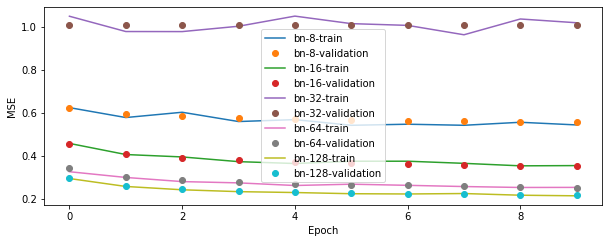

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSE')
for bn, loss in losses.items():
  plt.plot(loss['train_loss'], label='bn-{}-train'.format(bn))
  plt.plot(loss['val_loss'], 'o', label='bn-{}-validation'.format(bn))
plt.legend()
plt.show()

# <h3><b>Test and display 5 images</h3></b>

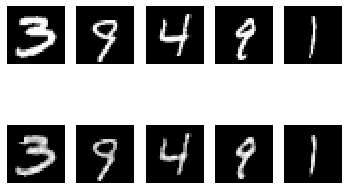

In [70]:
# select N images
N = 5
test_images = random.sample(list(mnist_testset),N)
image_loader = torch.utils.data.DataLoader(
    test_images,
    shuffle=False)
device = hparams['device']

# create plot
f, axarr = plt.subplots(2,N)
for i, (image, label) in enumerate(image_loader):
  with torch.no_grad():
    image = image.to(device)
    output = net(image)
    original_image = image.squeeze().data.numpy()
    output_image = output.squeeze().data.numpy()
    axarr[0,i].imshow(original_image,cmap='gray')
    axarr[0,i].axis('off')
    axarr[1,i].imshow(output_image,cmap='gray')
    axarr[1,i].axis('off')
plt.show()


# <h3><b>Creation of new images with the encoder</h3></b>

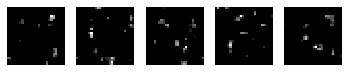

In [101]:
# extract decoder from autoencoder
decoder = net.decoder
# create random input
rand_inputs = torch.randn(5,128)
# plot images from random inputs
f, axarr = plt.subplots(1,N)
for i, rand_input in enumerate(rand_inputs):
  with torch.no_grad():
    rand_input = rand_input.to(device)
    output = decoder(rand_input)
    output_image = output.squeeze().data.numpy()
    axarr[i].imshow(output_image,cmap='gray')
    axarr[i].axis('off')
plt.show()


**Exercice 2:** Transfer learning




1.   Select a subset of 100 images and their associated labels from the MNIST training data.
2.   Select one of the previously trained autoencoders.
3.   Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
4.   Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
5.   Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
6.   From scratch: train the model on the 100 samples without reusing the decoder weights at all.
7.   Show the accuracy of the four models on the MNIST test set in a table.




<h3><b>Create subset of 100 images</h3></b>

In [0]:
train_size = 100
train_images = random.sample(list(mnist_trainset),train_size)
train_loader = torch.utils.data.DataLoader(
    train_images,
    batch_size= train_size,
    shuffle=True)
device = hparams['device']

<h3><b> Select the encoder from the previous exercice </h3></b>

In [0]:
encoder = net.encoder

<h3><b> Create a classificator from the previous encoder and FCL </h3></b>

In [0]:
class Classificator(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.encoder = encoder
    self.fc = nn.Sequential(
      nn.Linear(128, hparams['num_classes']),
      nn.LogSoftmax()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc(x)
    return x

<h3><b>Define Train and Test/Validation methods</b></h3>

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_class_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

def test_class_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

<h3><b> Train the classificator only training the FCL </h3></b>

In [26]:
print("Training only the FCL")
train_losses1 = []
validation_losses1 = []
validation_accs1 = []
class1 = Classificator(encoder.requires_grad_(requires_grad=False))
class1.to(hparams['device'])
optimizer = optim.RMSprop(class1.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(40):
  train_losses1.append(train_class_epoch(train_loader, class1, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class1, hparams)
  validation_losses1.append(te_loss)
  validation_accs1.append(te_acc)

Training only the FCL
Train Epoch: 0 [0/100 (0%)]	Loss: 10.750607


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 7.6085, Accuracy: 939/10000 (9%)

Train Epoch: 1 [0/100 (0%)]	Loss: 7.829157

Test set: Average loss: 4.1738, Accuracy: 1121/10000 (11%)

Train Epoch: 2 [0/100 (0%)]	Loss: 4.421165

Test set: Average loss: 3.1062, Accuracy: 842/10000 (8%)

Train Epoch: 3 [0/100 (0%)]	Loss: 3.001906

Test set: Average loss: 2.8802, Accuracy: 1432/10000 (14%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.727426

Test set: Average loss: 2.7530, Accuracy: 1310/10000 (13%)

Train Epoch: 5 [0/100 (0%)]	Loss: 2.585125

Test set: Average loss: 2.6400, Accuracy: 1765/10000 (18%)

Train Epoch: 6 [0/100 (0%)]	Loss: 2.469846

Test set: Average loss: 2.4629, Accuracy: 1792/10000 (18%)

Train Epoch: 7 [0/100 (0%)]	Loss: 2.272913

Test set: Average loss: 2.3736, Accuracy: 2292/10000 (23%)

Train Epoch: 8 [0/100 (0%)]	Loss: 2.169797

Test set: Average loss: 2.2989, Accuracy: 2103/10000 (21%)

Train Epoch: 9 [0/100 (0%)]	Loss: 2.063768

Test set: Average loss: 2.2208, Accuracy: 2789/10000 (28%)

Train E

<h3><b> Train the classificator using the pretrained weights as initial values </h3></b>

In [27]:
print("Training with the pretarained weights")
train_losses2 = []
validation_losses2 = []
validation_accs2 = []
class2 = Classificator(encoder.requires_grad_(requires_grad=True))
class2.to(hparams['device'])
optimizer = optim.RMSprop(class2.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(40):
  train_losses2.append(train_class_epoch(train_loader, class2, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class2, hparams)
  validation_losses2.append(te_loss)
  validation_accs2.append(te_acc)

Training with the pretarained weights
Train Epoch: 0 [0/100 (0%)]	Loss: 5.972706


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 6.7413, Accuracy: 1057/10000 (11%)

Train Epoch: 1 [0/100 (0%)]	Loss: 6.086668

Test set: Average loss: 2.4556, Accuracy: 2375/10000 (24%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.362423

Test set: Average loss: 2.2671, Accuracy: 2719/10000 (27%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.163588

Test set: Average loss: 2.2019, Accuracy: 3018/10000 (30%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.071115

Test set: Average loss: 2.1355, Accuracy: 3708/10000 (37%)

Train Epoch: 5 [0/100 (0%)]	Loss: 1.965279

Test set: Average loss: 2.0431, Accuracy: 4504/10000 (45%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.822814

Test set: Average loss: 1.9267, Accuracy: 4930/10000 (49%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.640316

Test set: Average loss: 1.7823, Accuracy: 5319/10000 (53%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.417456

Test set: Average loss: 1.6208, Accuracy: 5690/10000 (57%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.174179

Test set: Average loss: 1.4576, Accuracy: 6316/10000 (63%)

Tra

<h3><b> Train the classificator with different learning rates </h3></b>

In [33]:
print("Training with different learning rates")
train_losses3 = []
validation_losses3 = []
validation_accs3 = []
class3 = Classificator(encoder.requires_grad_(requires_grad=True))
class3.to(hparams['device'])
optimizer = optim.RMSprop([{'params': class3.encoder.parameters(), "lr": hparams['learning_rate']/10},
                           {'params': class3.fc.parameters(), "lr" :hparams['learning_rate']}])
criterion = F.nll_loss

for epoch in range(40):
  train_losses3.append(train_class_epoch(train_loader, class3, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class3, hparams)
  validation_losses3.append(te_loss)
  validation_accs3.append(te_acc)

Training with different learning rates
Train Epoch: 0 [0/100 (0%)]	Loss: 4.778375


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 3.1670, Accuracy: 1847/10000 (18%)

Train Epoch: 1 [0/100 (0%)]	Loss: 2.806641

Test set: Average loss: 2.0547, Accuracy: 3442/10000 (34%)

Train Epoch: 2 [0/100 (0%)]	Loss: 1.859348

Test set: Average loss: 1.7208, Accuracy: 4085/10000 (41%)

Train Epoch: 3 [0/100 (0%)]	Loss: 1.307697

Test set: Average loss: 1.4579, Accuracy: 5239/10000 (52%)

Train Epoch: 4 [0/100 (0%)]	Loss: 1.019089

Test set: Average loss: 1.3289, Accuracy: 5591/10000 (56%)

Train Epoch: 5 [0/100 (0%)]	Loss: 0.817894

Test set: Average loss: 1.2020, Accuracy: 6085/10000 (61%)

Train Epoch: 6 [0/100 (0%)]	Loss: 0.671295

Test set: Average loss: 1.1299, Accuracy: 6221/10000 (62%)

Train Epoch: 7 [0/100 (0%)]	Loss: 0.562330

Test set: Average loss: 1.0525, Accuracy: 6561/10000 (66%)

Train Epoch: 8 [0/100 (0%)]	Loss: 0.475992

Test set: Average loss: 1.0054, Accuracy: 6717/10000 (67%)

Train Epoch: 9 [0/100 (0%)]	Loss: 0.409900

Test set: Average loss: 0.9584, Accuracy: 6879/10000 (69%)

Tra

<h3><b> Train the classificator from scratch </h3></b>

In [34]:
print("Training from scratch")
train_losses4 = []
validation_losses4 = []
validation_accs4 = []
class4 = Classificator(ConvEncoder(128))
class4.to(hparams['device'])
optimizer = optim.RMSprop(class4.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(40):
  train_losses4.append(train_class_epoch(train_loader, class4, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class4, hparams)
  validation_losses4.append(te_loss)
  validation_accs4.append(te_acc)

Training from scratch
Train Epoch: 0 [0/100 (0%)]	Loss: 2.311878


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 9.5088, Accuracy: 1032/10000 (10%)

Train Epoch: 1 [0/100 (0%)]	Loss: 8.413711

Test set: Average loss: 2.4934, Accuracy: 1962/10000 (20%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.452377

Test set: Average loss: 2.2457, Accuracy: 2201/10000 (22%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.206530

Test set: Average loss: 2.1014, Accuracy: 3493/10000 (35%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.003795

Test set: Average loss: 1.8520, Accuracy: 3890/10000 (39%)

Train Epoch: 5 [0/100 (0%)]	Loss: 1.663602

Test set: Average loss: 1.5305, Accuracy: 5243/10000 (52%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.265345

Test set: Average loss: 1.6754, Accuracy: 4466/10000 (45%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.315313

Test set: Average loss: 1.7222, Accuracy: 4756/10000 (48%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.350930

Test set: Average loss: 1.2639, Accuracy: 5722/10000 (57%)

Train Epoch: 9 [0/100 (0%)]	Loss: 0.911769

Test set: Average loss: 0.9856, Accuracy: 7206/10000 (72%)

Tra

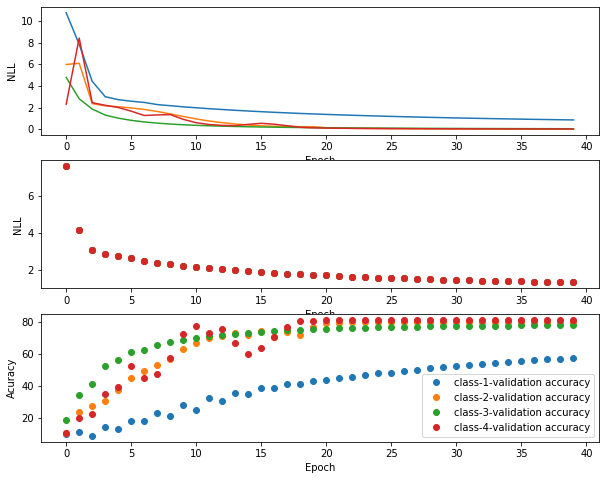

In [35]:
plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.plot(train_losses1, label='class-{}-validation losses'.format(1))
plt.plot(train_losses2, label='class-{}-validation losses'.format(2))
plt.plot(train_losses3, label='class-{}-validation losses'.format(3))
plt.plot(train_losses4, label='class-{}-validation losses'.format(4))
plt.subplot(3,1,2)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.plot(validation_losses1,'o', label='class-{}-validation losses'.format(1))
plt.plot(validation_losses1,'o', label='class-{}-validation losses'.format(2))
plt.plot(validation_losses1,'o', label='class-{}-validation losses'.format(3))
plt.plot(validation_losses1,'o', label='class-{}-validation losses'.format(4))
plt.subplot(3,1,3)
plt.xlabel('Epoch')
plt.ylabel('Acuracy')
plt.plot(validation_accs1,'o', label='class-{}-validation accuracy'.format(1))
plt.plot(validation_accs2,'o', label='class-{}-validation accuracy'.format(2))
plt.plot(validation_accs3,'o', label='class-{}-validation accuracy'.format(3))
plt.plot(validation_accs4,'o', label='class-{}-validation accuracy'.format(4))
plt.legend()
plt.show()